# LOICA Consortia demonstration

In [ ]:
pip install -e .

In [ ]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

This notebook shows the novel functionality that has been encoded in git branch Consortia

This LOICA update allows to create strains that belong to class Strain, taking genetic network and metabolism as parameters.

## Test producer strain
First, set up metabolism and genetic network as usual

In [ ]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab1 = lc.SimulatedMetabolism("Simulated metabolism 1", biomass, growth_rate)
genetic_n1 = lc.GeneticNetwork()

Then define strain. Strain class also has parameter cell_volume, which is by default set to 10^-15 L

In [ ]:
test_strain = lc.Strain('Test strain', genetic_n1, metab1)
# test
print(test_strain.name)
print(test_strain.cell_volume)

Now, create genetic network as usual. 

### No diffusion

Each gene product now has parameter diffusion_rate (representing permeability constant). 

LOICA Consortia assumes that:
- all molecules are distrubed equally both incracellularly and extracellularly, so the only diffusion gradient exists between extracellular space and inside of the cell. 
- all cells belonging to the same strain are of uniform size. 

Based on that, diffusion rate here is the proportion of concentration that gets transferred either in- or outside of the cell per change of time. This parameter depend on the average surface area of the cell in the strain.

In [ ]:
# Create and add reporter to genetic network
reporter = lc.Reporter(name='GFP', color='green', degradation_rate=0, init_concentration=0)
genetic_n1.add_reporter(reporter)

# Constitutive exression of reporter from strain
source = lc.Source(output=reporter, rate=5.38*10**-7)
genetic_n1.add_operator(source)

Now we have a strain that constitutively expresses GFP. 

Since we have not set diffusion rate, if we create sample, assay and run the latter then check the reporter extracellular concentration, it will stay 0:

In [ ]:
sample = lc.Sample(strain=test_strain)
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='GFP constittive expression',
                description='Simulated GFP expression in test strain'
                )

Setting parameter track_all to true will record both intracellular and extracellular concentrations of all GeneProducts in the systems, as well as biomass without accounting for noise and background.

In [ ]:
assay.run(substeps=50, mode='track_all')

In [ ]:
m = assay.measurements
fig,ax = plt.subplots()
m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', color='green', style='.', ax=ax)
m[m.Signal=='GFP in Test strain'].plot(x='Time', y='Measurement', color='green', style='-', ax=ax)
ax.legend(['Extracellular GFP', 'Internal GFP'])
fig1,ax1 = plt.subplots()
m[m.Signal=='Test strain biomass'].plot(x='Time', y='Measurement', style='-', ax=ax1)
ax1.legend(['Biomass'])

### With diffusion

In [ ]:
metab2 = lc.SimulatedMetabolism("Simulated metabolism 2", biomass, growth_rate)
genetic_n2 = lc.GeneticNetwork()
test_strain2 = lc.Strain('Test strain', genetic_n2, metab2)

Now let's add diffusible signal C14 with diffusion rate 1 (all difference gets trasferred) that would also be continiously expressed.

In [ ]:
regulator = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=126)
genetic_n2.add_regulator(regulator)

source_2 = lc.Source(output=regulator, rate=5.38*10**-7)
genetic_n2.add_operator(source_2)

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=100)
genetic_n2.draw()

By default, sample volume is 0.0002 L (200 ul). You can change volume by entering a different value into parameter volume.

In [ ]:
sample2 = lc.Sample(strain=test_strain2, volume=0.0002)
assay2 = lc.Assay([sample2], 
                n_measurements=100, 
                interval=0.24,
                name='C14 constittive expression',
                description='Simulated C14 expression in test strain'
                )

In [ ]:
assay2.run(substeps=50, mode='track_all')

In [ ]:
m = assay2.measurements
fig,ax = plt.subplots()
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', color='orange', style='.', ax=ax)
ax.legend(['Extracellular C14'])
fig2, ax2 = plt.subplots()
m[m.Signal=='C14 in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
ax2.legend(['C14 in Test strain'])


As you can see, external C14 concentration is low, but is steadily increasing as the experiment goes on.

### Extracellular degradation

It is also possible to set extracellular degradation rate for any GeneProduct.

In [ ]:
sample2.set_extracel_degr("C14", 0.017)
assay3 = lc.Assay([sample2], 
                n_measurements=100, 
                interval=0.24,
                name='C14 constittive expression with C14 extracellular degradation',
                description='Simulated C14 expression in test strain'
                )

In [ ]:
assay3.run(substeps=50, mode='track_all')

In [ ]:
m = assay3.measurements
fig,ax = plt.subplots()
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', color='orange', style='.', ax=ax)
ax.legend(['Extracellular C14'])
fig2,ax2 = plt.subplots()
m[m.Signal=='C14 in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
ax2.legend(['C14 in Test strain'])

Here, you can see that external concentration is generally lower due to external degradation, and it eventually reaches steady-state where degradation and diffusion balance out.

## Sender-Receiver consortium

### Sender strain

In [ ]:
def growth_rate_sender(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass_sender(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_sender = lc.SimulatedMetabolism("Simulated metabolism receiver", biomass_sender, growth_rate_sender)
genetic_network_sender = lc.GeneticNetwork()
sender = lc.Strain('Sender', genetic_network_sender, metab_sender)
# test
print(sender.name)

In [ ]:
# Create and add reporter to genetic network
signal = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=126)
genetic_network_sender.add_regulator(signal)

# Constitutive exression of signal in sender
signal_source = lc.Source(output=signal, rate=5.38*10**-7)
genetic_network_sender.add_operator(signal_source)

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=100)
genetic_network_sender.draw()

### Receiver strain

In [ ]:
def growth_rate_receiver(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass_receiver(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_receiver = lc.SimulatedMetabolism("Simulated metabolism receiver", biomass_receiver, growth_rate_receiver)
genetic_network_receiver = lc.GeneticNetwork()
receiver = lc.Strain('Receiver', genetic_network_receiver, metab_receiver)
# test
print(receiver.name)

When defining multiple strains, if molecule can diffuse to cell ("receiver") that doesn't belong to the producer strain, it has to be defined within the "receiver" strain as well. Since instance of GeneProduct has own internal concentration, assigning the same value for different genetic networks will not work, as different strains with different degetic networks will have different dynamics. 

In [ ]:
# Create and add regulator to genetic network
signal_in_r = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=126)
genetic_network_receiver.add_regulator(signal_in_r)

# Create and add reporter
gfp = lc.Reporter(name='GFP', degradation_rate=0, init_concentration=0)
genetic_network_receiver.add_reporter(gfp)

# Exression of GFP activated by C14
c14_to_gfp = lc.Hill1(name='Pcin', input=signal_in_r, output=gfp, alpha=[0, 5.20*10**-8], K=3.41*10**-6, n=1.87)
genetic_network_receiver.add_operator(c14_to_gfp)

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=100)
genetic_network_receiver.draw()

### Set up sample and simulate

In [ ]:
s_r_consortium = lc.Sample(strain=[sender, receiver])
s_r_assay = lc.Assay([s_r_consortium], 
                n_measurements=100, 
                interval=0.24,
                name='GFP expression in receiver strain',
                description='Simulated sender-receiver consortium'
                )

In [ ]:
s_r_assay.run(substeps=50, mode='track_all')

In [ ]:
m = s_r_assay.measurements
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='GFP in Sender'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='GFP in Receiver'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', color='red', style='.', ax=ax1)
m[m.Signal=='C14 in Sender'].plot(x='Time', y='Measurement', color='red', style='-', ax=ax)
m[m.Signal=='C14 in Receiver'].plot(x='Time', y='Measurement', color='red', style='--', ax=ax3)
ax.legend(['GFP in Sender', 'C14 in Sender'])
ax1.legend(['Extracellular GFP', 'Extracellular C14'])
ax2.legend(['GFP in Receiver'])
ax3.legend(['C14 in Receiver'])

# Diffusible supplement

You can set a signal to be continuously added at the same concentration to the the sample. In the code below, we create receiver strain that produces GFP when C14 is present. Then we create supplement C14.

In [ ]:
pip install -e .

In [ ]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Receiver strain

In [ ]:
def growth_rate_receiver(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass_receiver(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_receiver = lc.SimulatedMetabolism("Simulated metabolism receiver", biomass_receiver, growth_rate_receiver)
genetic_network_receiver = lc.GeneticNetwork()
receiver = lc.Strain('Receiver', genetic_network_receiver, metab_receiver)
# test
print(receiver.name)

In [ ]:
# Create and add regulator to genetic network
signal = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=126)
genetic_network_receiver.add_regulator(signal)

# Create and add reporter
gfp = lc.Reporter(name='GFP', degradation_rate=0, init_concentration=0)
genetic_network_receiver.add_reporter(gfp)

# Exression of GFP activated by C14
c14_to_gfp = lc.Hill1(name='Pcin', input=signal, output=gfp, alpha=[0, 5.20*10**-8], K=3.41*10**-6, n=1.87)
genetic_network_receiver.add_operator(c14_to_gfp)

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=100)
genetic_network_receiver.draw()

Add supplement. Make sure that the name is the same as the as the regulator name that belongs to the receiver strain.

In [ ]:
supplement = lc.Supplement(name='C14')

### Set up sample, set supplement and simulate

In [ ]:
receiver_sample = lc.Sample(strain=receiver)
receiver_sample.set_supplement(supplement, 0.0001)
receiver_assay = lc.Assay([receiver_sample], 
                n_measurements=100, 
                interval=0.24,
                name='GFP expression in receiver strain based on supplement diffusion',
                description='Simulated receiver strain'
                )

In [ ]:
receiver_assay.run(substeps=50, stochastic=False, mode='track_all')

In [ ]:
m = receiver_assay.measurements
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='GFP in Receiver'].plot(x='Time', y='Measurement', color='green', style='-', ax=ax2)
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', color='red', style='.', ax=ax)
m[m.Signal=='C14 in Receiver'].plot(x='Time', y='Measurement', color='red', style='--', ax=ax1)
fig3, ax3 = plt.subplots()
m[m.Signal=='Receiver biomass'].plot(x='Time', y='Measurement', color='purple', style='-', ax=ax3)
ax.legend(['Extracellular GFP', 'Extracellular C14'])
ax1.legend(['C14 in Receiver'])
ax2.legend(['GFP in Receiver'])
ax3.legend(['Receiver biomass'])

# Set initial external concentration

You can set a starting external concentration of signal. In the code below, we create receiver strain that produces GFP when C14 is present. Then we add C14 at the start of the experiment.

In [ ]:
pip install -e .

In [1]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Receiver strain

In [2]:
def growth_rate_receiver(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass_receiver(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_receiver = lc.SimulatedMetabolism("Simulated metabolism receiver", biomass_receiver, growth_rate_receiver)
genetic_network_receiver = lc.GeneticNetwork()
receiver = lc.Strain('Receiver', genetic_network_receiver, metab_receiver)
# test
print(receiver.name)

Receiver


In [3]:
# Create and add regulator to genetic network
signal = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=126)
genetic_network_receiver.add_regulator(signal)

# Create and add reporter
# gfp = lc.Reporter(name='GFP', degradation_rate=0, init_concentration=0)
# genetic_network_receiver.add_reporter(gfp)

# Exression of GFP activated by C14
# c14_to_gfp = lc.Hill1(name='Pcin', input=signal, output=gfp, alpha=[0, 5.20*10**-8], K=3.41*10**-6, n=1.87)
# genetic_network_receiver.add_operator(c14_to_gfp)

### Set up sample, set starting concentration and simulate

In [4]:
receiver2_sample = lc.Sample(strain=receiver)
receiver2_sample.set_ext_conc('C14', 0.001)
print(signal.init_ext_conc)

0.001


In [5]:
receiver2_assay = lc.Assay([receiver2_sample], 
                n_measurements=100, 
                interval=0.24,
                name='GFP expression in receiver strain based on C14 diffusion',
                description='Simulated receiver strain'
                )

With substeps = 100, dt = 0.0024, so D*dt = 126*0.0024 = 0.3024, which is less than 1. As long as D*dt < 1 diffusion is gradual, concentration is not passed back and forward in single cell model. 

With ppod=50,000, starting cell number is 0.0002 L * 0.1 OD * 50,000 cells/L/OD = 1 cell

In [6]:
receiver2_assay.run(substeps=100, mode='track_all', ppod=50000)

100%|██████████| 100.0/100 [11:57<00:00,  7.18s/it]


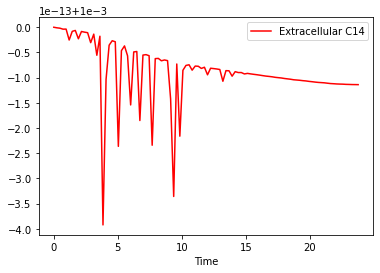

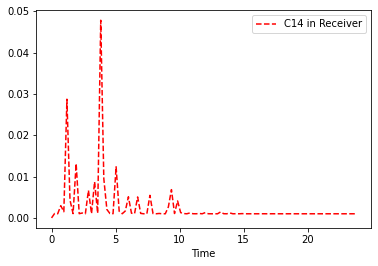

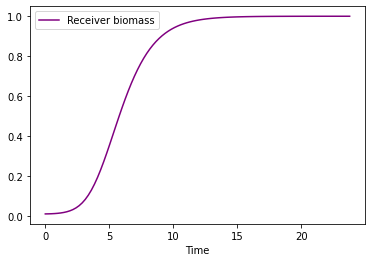

In [7]:
m = receiver2_assay.measurements
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
# fig2,ax2 = plt.subplots()
# m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='GFP in Receiver'].plot(x='Time', y='Measurement', color='green', style='-', ax=ax2)
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', color='red', style='-', ax=ax)
m[m.Signal=='C14 in Receiver'].plot(x='Time', y='Measurement', color='red', style='--', ax=ax1)
fig3, ax3 = plt.subplots()
m[m.Signal=='Receiver biomass'].plot(x='Time', y='Measurement', color='purple', style='-', ax=ax3)
# ax.legend(['Extracellular GFP', 'Extracellular C14'])
ax.legend(['Extracellular C14'])
ax1.legend(['C14 in Receiver'])
# ax2.legend(['GFP in Receiver'])
ax3.legend(['Receiver biomass'])